In [27]:
import os
import logging
from pathlib import Path

import scanpy as sc
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import pytorch_lightning as pl
import wandb
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from einops import rearrange, reduce
from timm import create_model
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import RandomResizedCrop, RandomRotation, Compose, CenterCrop, RandomHorizontalFlip, RandomVerticalFlip, Normalize
from typing import Optional, List

In [3]:
wandb.login()

wandb: Currently logged in as: estorrs (tme-st). Use `wandb login --relogin` to force relogin


True

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

In [6]:
import mushroom.utils as utils
from mushroom.models.unet import Unet

#### input data

In [7]:
fps = sorted(utils.listfiles('/data/estorrs/sandbox/mushroom/data/test_classes/', regex=r'.npy$'))
fps

['/data/estorrs/sandbox/mushroom/data/test_classes/BR_206B1_U2.npy',
 '/data/estorrs/sandbox/mushroom/data/test_classes/BR_206B1_U3.npy',
 '/data/estorrs/sandbox/mushroom/data/test_classes/BR_206B1_U4.npy',
 '/data/estorrs/sandbox/mushroom/data/test_classes/BR_206B1_U5.npy']

In [8]:
sid_to_masks = {}
for fp in fps:
    sid = fp.split('/')[-1].split('.')[0]
    sid_to_masks[sid] = torch.tensor(np.load(fp), dtype=torch.bool)
sid_to_masks.keys()

dict_keys(['BR_206B1_U2', 'BR_206B1_U3', 'BR_206B1_U4', 'BR_206B1_U5'])

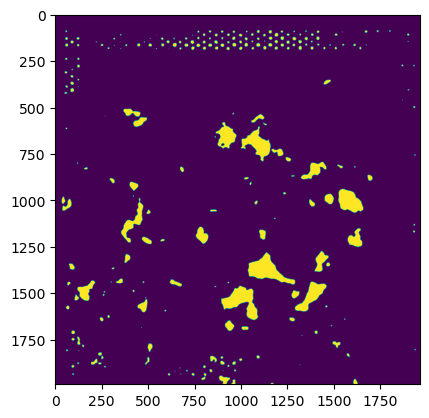

In [9]:
plt.imshow(next(iter(sid_to_masks.values()))[0])

In [10]:
bbox = (300,1800,200,1700)

sid_to_masks = {k:v[:, bbox[0]:bbox[1], bbox[2]:bbox[3]] for k, v in sid_to_masks.items()}

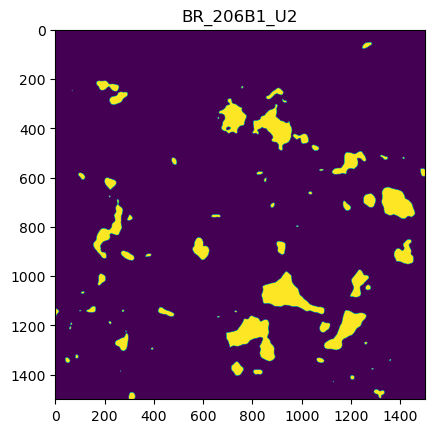

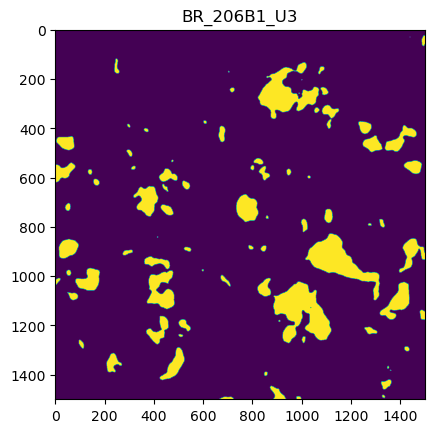

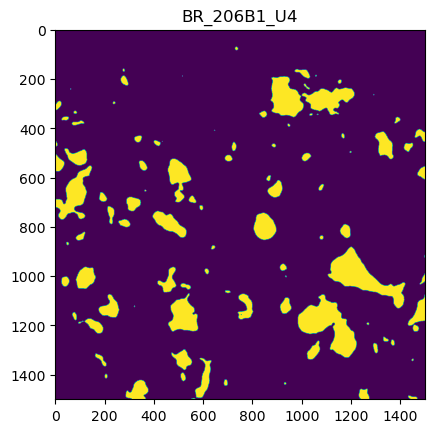

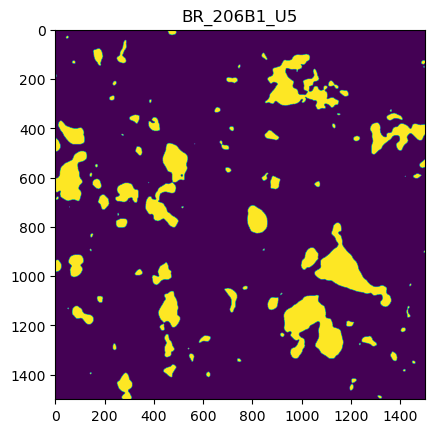

In [11]:
for k, v in sid_to_masks.items():
    plt.imshow(v[0])
    plt.title(k)
    plt.show()

In [12]:
def labeled_image_from_masks(masks, order=None):
    if order is None:
        order = np.arange(masks.shape[0])
    new = torch.zeros((masks.shape[-2], masks.shape[-1]), dtype=torch.long)
    for i in order:
        new[masks[i]] = i + 1
    return new

In [13]:
# bgn, il7r, epcam
order = [2, 0, 1]
sid_to_labeled = {k:labeled_image_from_masks(v, order=order)
                  for k, v in sid_to_masks.items()}

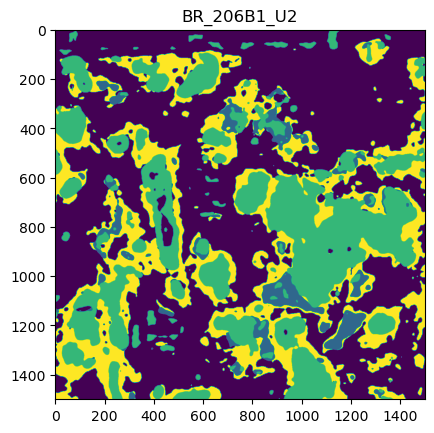

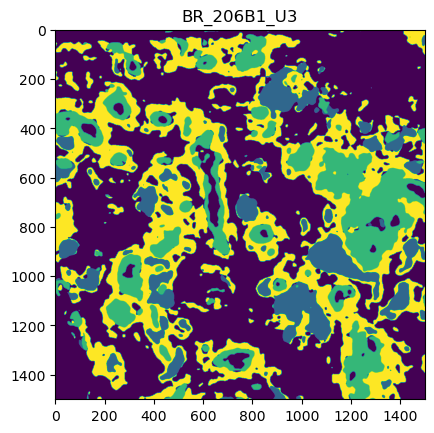

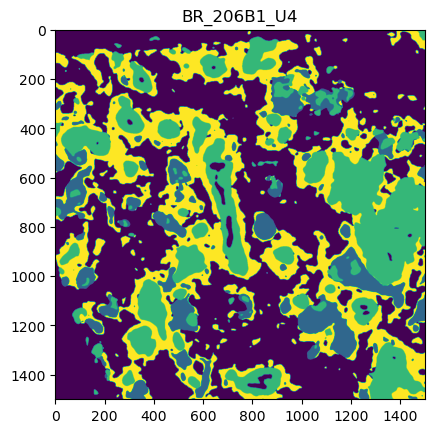

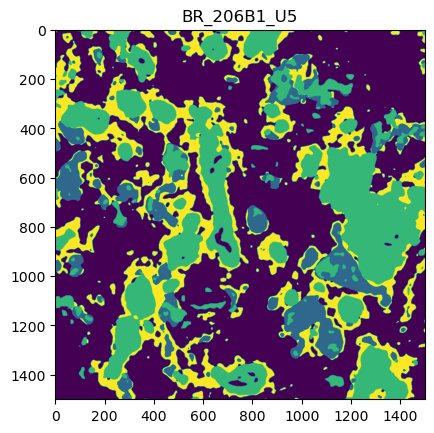

In [14]:
for k, v in sid_to_labeled.items():
    plt.imshow(v)
    plt.title(k)
    plt.show()

In [15]:
x = next(iter(sid_to_labeled.values()))
x

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [3, 3, 3,  ..., 0, 0, 0],
        [3, 3, 3,  ..., 0, 0, 0],
        [3, 3, 3,  ..., 0, 0, 0]])

In [16]:
sample_order = ['BR_206B1_U2', 'BR_206B1_U3', 'BR_206B1_U4', 'BR_206B1_U5']
slices = [sid_to_labeled[sid] for sid in sample_order]
len(slices)

4

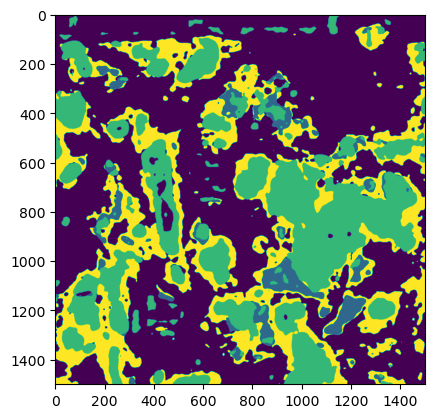

In [17]:
plt.imshow(slices[0])

In [18]:
cel = torch.nn.CrossEntropyLoss()

y_pred = torch.rand(1, 10, 256, 256)
y_true = (torch.randint(0, 10, (1, 256, 256)))

cel(y_pred, y_true)

tensor(2.3399)

In [19]:
# dice = DiceLoss()
# dice(y_pred, y_true)

In [21]:
slices[0].shape

torch.Size([1500, 1500])

In [26]:
x = torch.concat([s.unsqueeze(0) for s in slices]).to(torch.float32)
x.mean(), x.std()

(tensor(1.1301), tensor(1.2543))

In [28]:
class RegistrationTransform(object):
    def __init__(self, p=1., size=(128,128), scale=(.5, 1.0)):
        self.p = p
        
        self.spatial_transform = Compose([
            RandomResizedCrop(size, scale=scale),
            RandomHorizontalFlip(),
            RandomVerticalFlip()
#             RandomRotation(180),
#             CenterCrop(size)
        ])
  
    def __call__(self, x):
        """
        x - (2, H, W)
        """
        if torch.rand(size=(1,)) < self.p:
            x = self.spatial_transform(x)
        else:
            x = TF.resize(x, size)
        return x


In [29]:
class RegistrationDataset(Dataset):
    """Registration Dataset"""
    def __init__(self, slices, transform=RegistrationTransform(), length=128):
        """
        For now assuming slices are all same size.
        
        Trains on multiple slices interchangebly.
        """
        self.size = size
        self.length = length
        
        self.slices = slices
        
        self.stacked = []
        for i in range(len(slices) - 1):
            self.stacked.append(torch.concat(
                (slices[i].unsqueeze(0), slices[i+1].unsqueeze(0))))

        self.transform = transform
        self.normalize = Normalize((1.1301,), (1.2543,))
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        stack_index = idx % len(self.stacked)
        cropped = self.transform(self.stacked[stack_index])
        fixed, moving = cropped[:1], cropped[1:]
        return {
            'fixed': self.normalize(fixed.to(torch.float32)),
            'moving': self.normalize(moving.to(torch.float32)),
            'y': fixed.squeeze()
        }

In [30]:
size = (128, 128)
scale = (.4, 1.)
length = 128
num_classes = len(order) + 1

train_transform = RegistrationTransform(p=.9, size=size, scale=scale)

train_ds = RegistrationDataset(slices[:-1], transform=train_transform, length=128)

In [31]:
val_transform = RegistrationTransform(p=0.)

val_ds = RegistrationDataset(slices[-2:], transform=val_transform, length=1)

In [32]:
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=1)
val_dl = DataLoader(val_ds, batch_size=1)

In [33]:
d = val_ds[0]

In [34]:
len(val_ds)

1

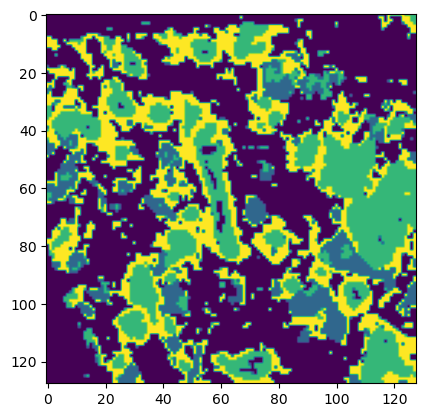

In [35]:
plt.imshow(d['fixed'][0])

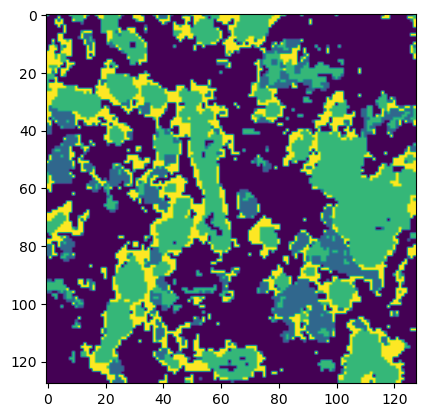

In [36]:
plt.imshow(d['moving'][0])

In [27]:
d = train_ds[0]

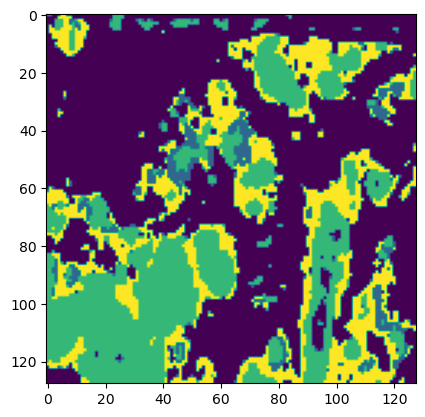

In [28]:
plt.imshow(d['fixed'][0])

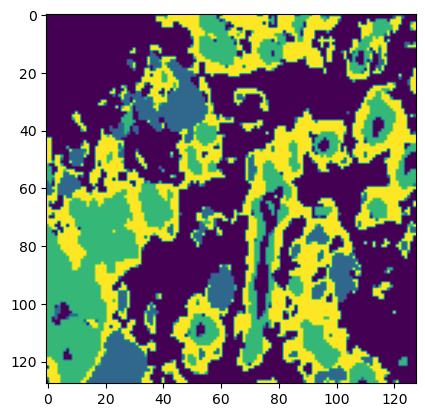

In [29]:
plt.imshow(d['moving'][0])

In [47]:
# https://segmentation-models-pytorch.readthedocs.io/en/latest/_modules/segmentation_models_pytorch/losses/dice.html#DiceLoss
def soft_dice_score(
    output: torch.Tensor,
    target: torch.Tensor,
    smooth: float = 0.0,
    eps: float = 1e-7,
    dims=None,
) -> torch.Tensor:
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        cardinality = torch.sum(output + target)
    dice_score = (2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps)
    return dice_score

class DiceLoss(torch.nn.Module):
    def __init__(
        self,
        mode='multiclass',
        classes=None,
        log_loss=False,
        from_logits=True,
        smooth=0.0,
        ignore_index=None,
        eps=1e-7,
    ):
        """Implementation of Dice loss for image segmentation task.
        It supports binary, multiclass and multilabel cases

        Args:
            mode: Loss mode 'binary', 'multiclass' or 'multilabel'
            classes:  List of classes that contribute in loss computation. By default, all channels are included.
            log_loss: If True, loss computed as `- log(dice_coeff)`, otherwise `1 - dice_coeff`
            from_logits: If True, assumes input is raw logits
            smooth: Smoothness constant for dice coefficient (a)
            ignore_index: Label that indicates ignored pixels (does not contribute to loss)
            eps: A small epsilon for numerical stability to avoid zero division error 
                (denominator will be always greater or equal to eps)

        Shape
             - **y_pred** - torch.Tensor of shape (N, C, H, W)
             - **y_true** - torch.Tensor of shape (N, H, W) or (N, C, H, W)

        Reference
            https://github.com/BloodAxe/pytorch-toolbelt
        """
        super(DiceLoss, self).__init__()
        self.mode = mode

        self.classes = classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.eps = eps
        self.log_loss = log_loss

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:

        assert y_true.size(0) == y_pred.size(0)

        if self.from_logits:
            # Apply activations to get [0..1] class probabilities
            # Using Log-Exp as this gives more numerically stable result and does not cause vanishing gradient on
            # extreme values 0 and 1
            if self.mode == 'multiclass':
                y_pred = y_pred.log_softmax(dim=1).exp()
            else:
                y_pred = F.logsigmoid(y_pred).exp()

        bs = y_true.size(0)
        num_classes = y_pred.size(1)
        dims = (0, 2)

        if self.mode == 'binary':
            y_true = y_true.view(bs, 1, -1)
            y_pred = y_pred.view(bs, 1, -1)

        if self.mode == 'multiclass':
            y_true = y_true.view(bs, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            y_true = F.one_hot(y_true, num_classes)  # N,H*W -> N,H*W, C
            y_true = y_true.permute(0, 2, 1)  # H, C, H*W

        if self.mode == 'multilabel':
            y_true = y_true.view(bs, num_classes, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

        scores = soft_dice_score(y_pred, y_true.type_as(y_pred), smooth=self.smooth, eps=self.eps, dims=dims)

        if self.log_loss:
            loss = -torch.log(scores.clamp_min(self.eps))
        else:
            loss = 1.0 - scores

        # Dice loss is undefined for non-empty classes
        # So we zero contribution of channel that does not have true pixels
        # NOTE: A better workaround would be to use loss term `mean(y_pred)`
        # for this case, however it will be a modified jaccard loss

        mask = y_true.sum(dims) > 0
        loss *= mask.to(loss.dtype)

        if self.classes is not None:
            loss = loss[self.classes]

        return loss.mean()

In [37]:
# adapted from https://github.com/DeepRegNet/DeepReg/blob/main/deepreg/loss/deform.py

def gradient_norm(x, l2=True):
    """x - (b c h w 3)"""
    # reshape to format in deepregnet
    x = rearrange(x, 'b c h w a -> b w h c a')
    # if x and y shapes are invalid raise error
    if x.shape[1] < 3 or x.shape[2] < 3:
        raise RuntimeError('cant compute gradient given x and/or y shape')

    dfdx = (x[:, 2:, :, :] - x[:, :-2, :, :]) / 2
    dfdy = (x[:, :, 2:, :] - x[:, :, :-2, :]) / 2
    # ignoring dfdz for now

    if not l2:
        norms = torch.abs(dfdx).mean() + torch.abs(dfdy).mean()
    else:
        norms = (dfdx**2).mean() + (dfdy**2).mean()
    return norms

# def bending_energy(x):
#     ddf = inputs
#     # first order gradient
#     # (batch, m_dim1-2, m_dim2-2, m_dim3-2, 3)
#     dfdx = (x[:, 2:, 1:-1, 1:-1] - x[:, :-2, 1:-1, 1:-1]) / 2
#     dfdy = (x[:, 1:-1, 2:, 1:-1] - x[:, 1:-1, :-2, 1:-1]) / 2
#     dfdz = (x[:, 1:-1, 1:-1, 2:] - x[:, 1:-1, 1:-1, :-2]) / 2

#     # second order gradient
#     # (batch, m_dim1-4, m_dim2-4, m_dim3-4, 3)
#     dfdxx = (dfdx[:, 2:, 1:-1, 1:-1] - dfdx[:, :-2, 1:-1, 1:-1]) / 2
#     dfdyy = (dfdy[:, 1:-1, 2:, 1:-1] - dfdy[:, 1:-1, :-2, 1:-1]) / 2
#     dfdzz = (dfdz[:, 1:-1, 1:-1, 2:] - dfdz[:, 1:-1, 1:-1, :-2]) / 2
#     dfdxy = (dfdx[:, 1:-1, 2:, 1:-1] - dfdx[:, 1:-1, :-2, 1:-1]) / 2
#     dfdyz = (dfdy[:, 1:-1, 1:-1, 2:] - dfdy[:, 1:-1, 1:-1, :-2]) / 2
#     dfdxz = (dfdx[:, 1:-1, 1:-1, 2:] - dfdx[:, 1:-1, 1:-1, :-2]) / 2

#     # (dx + dy + dz) ** 2 = dxx + dyy + dzz + 2*(dxy + dyz + dzx)
#     energy = dfdxx**2 + dfdyy**2 + dfdzz**2
#     energy += 2 * dfdxy**2 + 2 * dfdxz**2 + 2 * dfdyz**2
#     return energy.mean()

In [52]:
class RegistrationModel(nn.Module):
    """
    """

    def __init__(self, fixed_shape, n_classes,
                 backbone='resnet34',
                 intensity_scaler=.5, deformation_scaler=.5):
        super().__init__()
        self.n_classes = n_classes
        
        self.unet = Unet(in_chans=2, num_classes=16, backbone=backbone)
        self.ddfc_layer = nn.Conv2d(16, fixed_shape[1], kernel_size=1)
        self.ddfh_layer = nn.Conv2d(16, fixed_shape[1], kernel_size=1)
        self.ddfw_layer = nn.Conv2d(16, fixed_shape[1], kernel_size=1)
        
        # (b 1 h w)
        
        self.scale_factor = nn.Parameter(torch.zeros(1, 1, fixed_shape[2], fixed_shape[3]))
        
        
        self.fixed_shape = fixed_shape # (b, c, h, w)
        ref_grid_b, ref_grid_c, ref_grid_h, ref_grid_w = torch.meshgrid(
            torch.arange(self.fixed_shape[0]),
            torch.arange(self.fixed_shape[1]),
            torch.arange(self.fixed_shape[2]),
            torch.arange(self.fixed_shape[3])
        )
        self.ref_grid_b = torch.nn.Parameter(ref_grid_b, requires_grad=False)
        self.ref_grid_c = torch.nn.Parameter(ref_grid_c, requires_grad=False)
        self.ref_grid_h = torch.nn.Parameter(ref_grid_h, requires_grad=False)
        self.ref_grid_w = torch.nn.Parameter(ref_grid_w, requires_grad=False)
        
        # losses
        self.intensity_scaler = intensity_scaler
        self.deformation_scaler = deformation_scaler
        self.cel = nn.CrossEntropyLoss()
#         self.dice = DiceLoss()
           
    def warp(self, moving, ddf):
        """
        ddf - (b c h w a), a - chw
        moving - (b c h w)
        """
        c_idxs = torch.round(self.ref_grid_c + ddf[..., 0])
        h_idxs = torch.round(self.ref_grid_h + ddf[..., 1])
        w_idxs = torch.round(self.ref_grid_w + ddf[..., 2])
        
        mask = torch.zeros_like(ddf, dtype=torch.bool)
        mask[..., 0] = 1
        mask[..., 1] = (h_idxs >= 0) & (h_idxs < moving.shape[-2])
        mask[..., 2] = (w_idxs >= 0) & (w_idxs < moving.shape[-1])
        
        masked_ddf = ddf * mask
        
        c_idxs = torch.round(self.ref_grid_c + masked_ddf[..., 0]).to(torch.long)
        h_idxs = torch.round(self.ref_grid_h + masked_ddf[..., 1]).to(torch.long)
        w_idxs = torch.round(self.ref_grid_w + masked_ddf[..., 2]).to(torch.long)
        
        
        c_idxs = torch.clamp(torch.round(self.ref_grid_c + ddf[..., 0]),
                             min=0, max=moving.shape[1] - 1).to(torch.long)
#         h_idxs = torch.clamp(torch.round(self.ref_grid_h + ddf[..., 1]),
#                              min=0, max=moving.shape[2] - 1).to(torch.long)
#         w_idxs = torch.clamp(torch.round(self.ref_grid_w + ddf[..., 2]),
#                              min=0, max=moving.shape[3] - 1).to(torch.long)
        
        return moving[self.ref_grid_b, c_idxs, h_idxs, w_idxs], mask
        
    def calculate_loss(self, y, warped, ddf, mask):
        # don't consider pixel if it was an invalid movement
        valid_pixels = ~(mask.sum(dim=-1) < 3) # (b c h w)
        
        masked_y = y * valid_pixels.squeeze(dim=1)
        masked_warped = warped * valid_pixels
#         plt.imshow(masked_warped[0, 0, :, :])
#         plt.title('masked warped')
#         plt.show()
        
#         plt.imshow(masked_y[0, :, :])
#         plt.title('masked y')
#         plt.show()
        
        w = F.one_hot(masked_warped.to(torch.long), num_classes=self.n_classes)
        w = rearrange(w, 'b 1 h w n_classes -> b n_classes h w').to(torch.float32)
        intensity_loss = self.cel(w, y)
#         intensity_loss = dice(w, y)
        
        deformation_loss = gradient_norm(ddf, l2=True)
        
        overall_loss = intensity_loss * self.intensity_scaler + deformation_loss * self.deformation_scaler
        
        return {
            'intensity_loss': intensity_loss,
            'deformation_loss': deformation_loss,
            'loss': overall_loss
        }
        
    def forward(self, fixed, moving):
        """
        fixed - (b, 1, h, w)
        moving - (b, 1, h, w)
        """
        x = torch.concat((fixed, moving), dim=1) # (b, 2, h, w)
        latent = self.unet(x) # (b, 16, h, w)
        
        ddfc = self.ddfc_layer(latent) # (b, 1, h, w)
        ddfh = self.ddfh_layer(latent) # (b, 1, h, w)
        ddfw = self.ddfw_layer(latent) # (b, 1, h, w)
        
        ddfh *= self.scale_factor
        ddfw *= self.scale_factor
        
        ddf = torch.stack((ddfc, ddfh, ddfw)) # ((chw), b, 1, h, w)
        ddf = rearrange(ddf, 'a b c h w -> b c h w a')
        
        return ddf

In [72]:
b = next(iter(train_dl))

In [142]:
f = RegistrationModel(b['fixed'].shape, num_classes)

In [135]:
out = f(b['fixed'], b['moving'])

In [121]:
out.shape

torch.Size([16, 1, 128, 128, 3])

In [122]:
w, mask = f.warp(b['moving'], out)

In [123]:
loss = f.calculate_loss(b['y'], w, out, mask)
loss

{'intensity_loss': tensor(1.3589),
 'deformation_loss': tensor(0.1511, grad_fn=<AddBackward0>),
 'loss': tensor(0.7550, grad_fn=<AddBackward0>)}

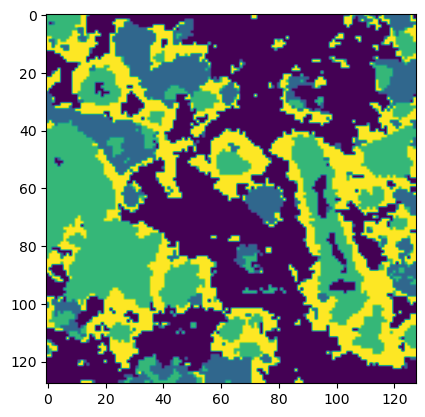

In [78]:
plt.imshow(w[0, 0])

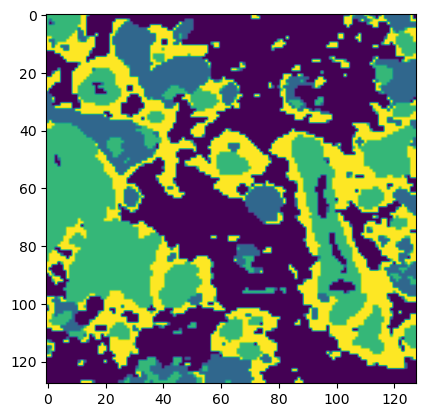

In [79]:
plt.imshow(b['moving'][0, 0])

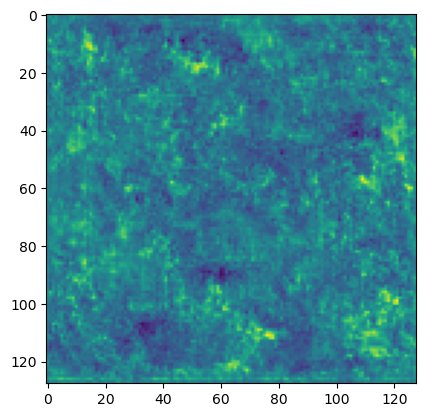

In [80]:
plt.imshow(out[0, 0, :, :, 0].detach().numpy())

In [81]:
out.shape

torch.Size([16, 1, 128, 128, 3])

In [143]:
test_ddf = torch.zeros_like(out)
test_ddf[..., -1] = 20.

In [144]:
w, mask = f.warp(b['moving'], test_ddf)

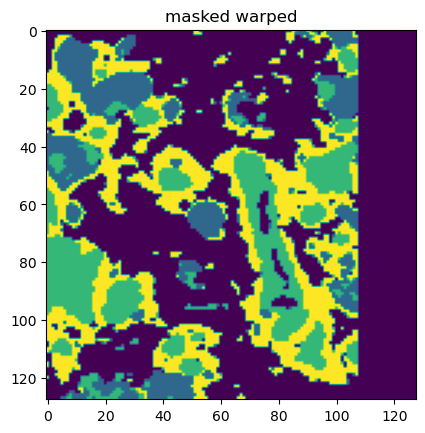

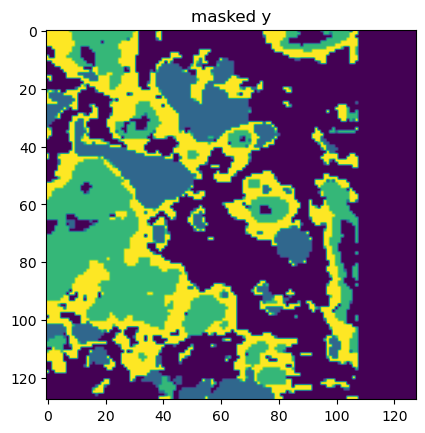

{'intensity_loss': tensor(1.3855),
 'deformation_loss': tensor(0.),
 'loss': tensor(0.6927)}

In [145]:
f.calculate_loss(b['y'], w, test_ddf, mask)

{'intensity_loss': tensor(1.3940),
 'deformation_loss': tensor(0.),
 'loss': tensor(0.6970)}

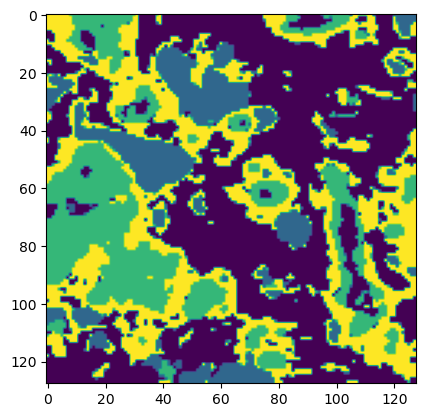

In [140]:
f.calculate_loss(b['y'], w, test_ddf, torch.ones_like(mask))

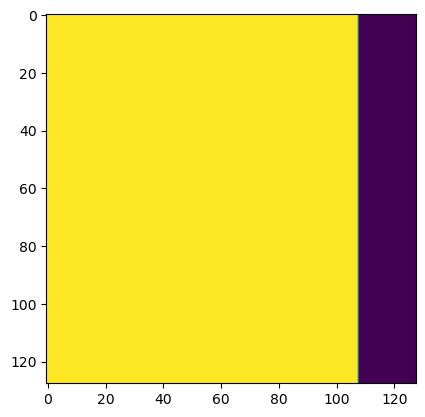

In [138]:
plt.imshow(mask[0, 0, :, :, -1])

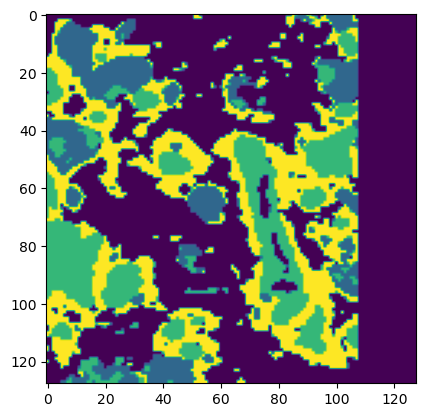

In [132]:
img = w * ~(mask.sum(dim=-1) < 3)
plt.imshow(img[0, 0])

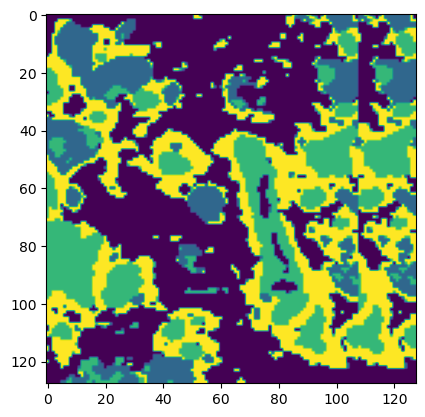

In [110]:
plt.imshow(w[0, 0])

In [ ]:
plt.imshow([0, 0])

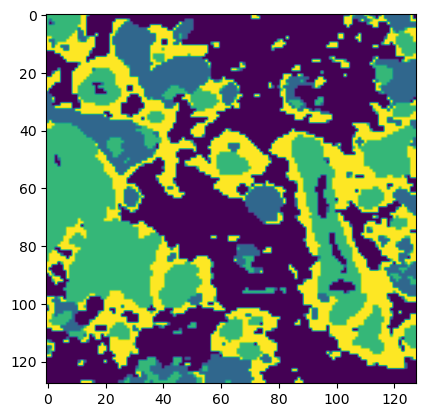

In [91]:
plt.imshow(b['moving'][0, 0])

In [53]:
class RegistrationModelLit(pl.LightningModule):
    def __init__(self, model, lr=1e-4):
        super().__init__()
        
        self.model = model
        self.lr = lr
        
        self.prev_ddf = None
        
#         self.save_hyperparameters(ignore=['model'])
        self.save_hyperparameters()

    def training_step(self, batch, batch_idx):
        fixed, moving, y = batch['fixed'], batch['moving'], batch['y']
        ddf = self.model(fixed, moving)
        warped, mask = self.model.warp(moving, ddf)
        
        loss = self.model.calculate_loss(y, warped, ddf, mask)
        loss = {f'train/{k}':v for k, v in loss.items()}
        
        self.log_dict(loss, on_step=False, on_epoch=True, prog_bar=True)
        
        result = {'loss': loss['train/loss'], 'loss_dict': loss, 'warped': warped, 'ddf': ddf, 'mask': mask}
        return result
    
    def validation_step(self, batch, batch_idx):
        fixed, moving, y = batch['fixed'], batch['moving'], batch['y']
        ddf = self.model(fixed, moving)
        warped, mask = self.model.warp(moving, ddf)
        loss = self.model.calculate_loss(y, warped, ddf, mask)
        loss = {f'train/{k}':v for k, v in loss.items()}
        
        self.log_dict(loss, on_step=False, on_epoch=True, prog_bar=True)
        
        result = {'loss': loss['train/loss'], 'loss_dict': loss, 'warped': warped, 'ddf': ddf, 'mask': mask}
        return result
    
    def prediction_step(self, batch, batch_idx):
        fixed, moving = batch['fixed'], batch['moving'], batch['y']
        ddf = self.model(fixed, moving)
        warped, mask = self.model.warp(moving, ddf)
                
        result = {'warped': warped, 'ddf': ddf, 'mask': mask}
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def forward(self, batch):
        return self.prediction_step(batch)

In [54]:
class LoggingCallback(pl.Callback):
    def __init__(self, log_every=10, log_n_samples=8):
        self.log_every = log_every
        self.log_n_samples = log_n_samples
    
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        if trainer.current_epoch % self.log_every == 0 and batch_idx==0:
            img = batch['fixed'][:self.log_n_samples].clone().detach().cpu()
            img -= img.min()
            img /= img.max()
            logger.log_image(
                key=f"train/fixed",
                images=[i[0] if i.shape[0] not in [1, 3] else i for i in img],
                caption=[i for i in range(img.shape[0])]
            )
            
            img = batch['moving'][:self.log_n_samples].clone().detach().cpu()
            img -= img.min()
            img /= img.max()
            logger.log_image(
                key=f"train/moving",
                images=[i[0] if i.shape[0] not in [1, 3] else i for i in img],
                caption=[i for i in range(img.shape[0])]
            )
            
            img = outputs['warped'][:self.log_n_samples].clone().detach().cpu()
            img -= img.min()
            img /= img.max()
            logger.log_image(
                key=f"train/warped",
                images=[i[0] if i.shape[0] not in [1, 3] else i for i in img],
                caption=[i for i in range(img.shape[0])]
            )
            img2 = batch['moving'][:self.log_n_samples].clone().detach().cpu()
            img2 -= img2.min()
            img2 /= img2.max()
            img = torch.abs(img - img2)
            logger.log_image(
                key=f"train/dispacement",
                images=[i[0] if i.shape[0] not in [1, 3] else i for i in img],
                caption=[i for i in range(img.shape[0])]
            )
            
            # dh
            img = outputs['ddf'][:self.log_n_samples].clone().detach().cpu()
            img = img[:, :, :, :, 1] 
            img -= img.min()
            img /= img.max()
            logger.log_image(
                key=f"train/ddf_h",
                images=[i[0] if i.shape[0] not in [1, 3] else i for i in img],
                caption=[i for i in range(img.shape[0])]
            )
            
            # dw
            img = outputs['ddf'][:self.log_n_samples].clone().detach().cpu()
            img = img[:, :, :, :, 2] 
            img -= img.min()
            img /= img.max()
            logger.log_image(
                key=f"train/ddf_w",
                images=[i[0] if i.shape[0] not in [1, 3] else i for i in img],
                caption=[i for i in range(img.shape[0])]
            )


In [55]:
project = 'registration_model'
log_dir = '/data/estorrs/mushroom/data/models/registration_v2'
Path(log_dir).mkdir(parents=True, exist_ok=True)

In [58]:
logger = WandbLogger(project=project, save_dir=log_dir)

In [59]:
# wandb.finish()

In [60]:
config = {
    'n_classes': num_classes,
    'fixed_shape': next(iter(train_dl))['fixed'].shape,
    'backbone': 'resnet34',
    'intensity_scaler': 1.,
    'deformation_scaler': .0,
    'training': {
        'log_n_samples': 4,
        'max_epochs': 100,
        'log_every': 5,
        'accelerator': 'gpu',
        'devices': [2],
        'lr': 1e-4,
        'precision': 32
    },
}
logger.experiment.config.update(config)

In [61]:
m = RegistrationModel(
    config['fixed_shape'],
    config['n_classes'],
    backbone=config['backbone'],
    intensity_scaler=config['intensity_scaler'],
    deformation_scaler=config['deformation_scaler']
)

model = RegistrationModelLit(m, lr=config['training']['lr'])

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:263: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [62]:
trainer = pl.Trainer(
    callbacks=[
        LoggingCallback(
            log_every=config['training']['log_every'],
            log_n_samples=config['training']['log_n_samples']
        ),
        ModelCheckpoint(
            dirpath=os.path.join(log_dir, "ckpts"),
            save_top_k=3, monitor="train/loss"
        )
    ],
    devices=config['training']['devices'],
    accelerator=config['training']['accelerator'],
    enable_checkpointing=True,
    max_epochs=config['training']['max_epochs'],
    precision=config['training']['precision'],
    logger=logger
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [63]:
trainer.fit(model=model, train_dataloaders=train_dl)

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /data/estorrs/mushroom/data/models/registration_v2/ckpts exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type              | Params
--------------------------------------------
0 | model | RegistrationModel | 25.5 M
--------------------------------------------
24.4 M    Trainable params
1.0 M     Non-trainable params
25.5 M    Total params
101.993   Total estimated model params size (MB)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/pytorch_lightning/trainer

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
